# Team Gamma - CME Mini S&P (ES)

## Data Preparation

### Import Libraries

In [1]:
import glob
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

### Configuration

In [2]:
MULTIPLIER = 50
COMMISSION = 0.85
TRAIN = 'TRAIN'
TEST = 'TEST'
TRAIN_PICKLE = 'TRAIN_PICKLE.pickle'
TEST_PICKLE = 'TEST_PICKLE.pickle'
TRAIN_DIR = 'TRAIN DATA/*.csv'
TEST_DIR = 'TEST DATA/*.csv'

### Serialize Data

In [ ]:
# Set to False if your serialized file has not yet been generated
# Remember to change back to "True" once the serialized file has been generated
DATA_SERIALIZED = True

if not DATA_SERIALIZED:
    
    # Writing files to pickle
    train_files = glob.glob(TRAIN_DIR)
    test_files = glob.glob(TEST_DIR)
    train_files.sort()
    test_files.sort()
    train_list = []
    test_list = []
    for filename in train_files:
        train_list.append(pd.read_csv(filename, index_col=0))
    for filename in test_files:
        test_list.append(pd.read_csv(filename, index_col=0))
    train = pd.concat(train_list)
    test = pd.concat(test_list)
    train.to_pickle(TRAIN_PICKLE)
    test.to_pickle(TEST_PICKLE)
    
    # Garbage collection
    del(train_files)
    del(test_files)
    del(train_list)
    del(test_list)
    del(train)
    del(test)
    gc.collect()


### Read Data

In [3]:
train_data = pd.read_pickle(TRAIN_PICKLE)
test_data = pd.read_pickle(TEST_PICKLE)
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

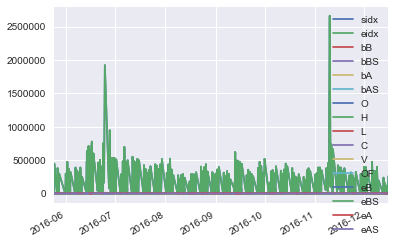

In [13]:
train_data.plot()
plt.show()

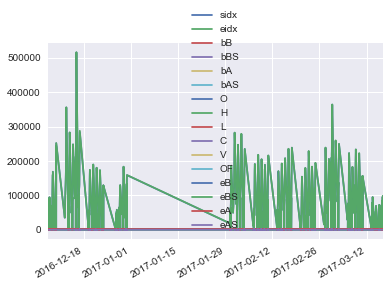

In [14]:
test_data.plot()
plt.show()

### Utility Functions

In [9]:
def filterData (data, columns):
    toReturn = data.loc[data['eB'] > 0, :] # Filter out no data rows
    return toReturn.loc[:, columns]

### Performance Measures

In [10]:
def winning_probability (pnls):
    if len(pnls) == 0:
        return np.nan
    positive = 0
    for pnl in pnls:
        if pnl > 0:
            positive += 1
    return positive / len(pnls)

def reward_to_risk_ratio (pnls):
    if len(pnls) == 0:
        return np.nan
    wins = []
    losses = []
    for pnl in pnls:
        if pnl > 0:
            wins.append(pnl)
        else:
            losses.append(pnl)
    return np.mean(wins) / abs(np.mean(losses))

def t_stat (pnls):
    if len(pnls) == 0:
        return np.nan
    return np.sqrt(len(pnls)) * (np.mean(pnls) / np.std(pnls))

## Order Flow Model (1)

### Data Preparation

In [4]:
OF1_COLUMNS = ['eB', 'eA', 'V', 'OF']

In [5]:
def init_of1_data (data):
    df = filterData(data, OF1_COLUMNS)
    df.rename(index=str, columns={'eB':'bid','eA':'ask','V':'volume','OF':'orderFlow'}, inplace=True)
    return df

In [15]:
test = init_of1_data(train_data)

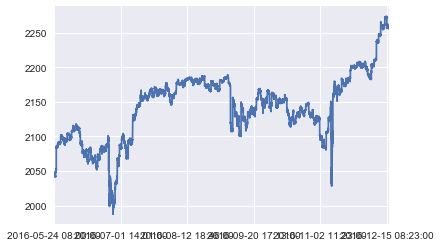

In [16]:
test['bid'].plot()

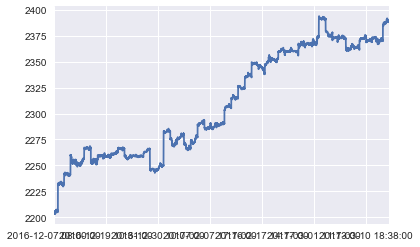

In [17]:
test2 = init_of1_data(test_data)
test2['bid'].plot()

### Parameters

In [ ]:
MINUTES = [1, 3, 5, 10, 15] # Holding Period
THRESHOLD = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] # Order Flow Threshold

### Model

In [7]:
def of1_model (data, HOLDING_PERIOD, OF_LIMIT):
    
    # Prepare initial data for manipulation
    df = init_of1_data(data)
    
    # Add signals [-1 : Sell, 0: None, 1: Buy]
    df['signal'] = df['orderFlow'].apply(lambda x : -1 if (abs(x) > OF_LIMIT and x > 0) else (1 if (abs(x) > OF_LIMIT and x < 0) else 0))

    # Add order signals [-1 : Sell, 0: None, 1: Buy]
    
    # Initialise order signals column
    df['order'] = 0
    i = 0 # counter
    while i < len(df):
    
        # Current row's signal
        curr_signal = df['signal'].iloc[i]

        # Check if current row's signal is not 0, else do nothing
        if curr_signal != 0:

            # Create index of row of closing position
            forward_index = i + HOLDING_PERIOD

            # Break if closing position is past last index
            if forward_index >= len(df):
                break

            forward_row = df.iloc[forward_index, :]

            # Store current signal in order column
            df['order'].iloc[i] = curr_signal

            #  Check if closing position row has a signal, else no signal
            while forward_row['signal'] != 0:

                # Check if closing position is coupled with an opposite signal, else advance counter
                if forward_row['signal'] != curr_signal:
                    df['order'].iloc[forward_index] = -curr_signal
                    break
                else:
                    forward_index += 1
                    # Break if closing position is past last index
                    if forward_index >= len(df):
                        break
                    forward_row = df.iloc[forward_index, :]

            else:
                # Store opposite closing signal in closing position row 
                df['order'].iloc[forward_index] = -curr_signal

            i = forward_index + 1

        else:
            i += 1
        
    df['transaction'] = df.apply(lambda x: x['bid'] * -1 if x['order'] > 0 else (x['ask'] if x['order'] < 0 else 0), axis=1)
    
    return df

### Backtest

In [ ]:
results_df = pd.DataFrame(columns=['Holding Period', 'Threshold', 'Winning Probability', 'Reward to Risk', 'T-Stat'])

In [ ]:
for holding_period in MINUTES:
    for of_limit in THRESHOLD:
        print(f'Holding Period: { holding_period } | Threshold: { of_limit }')
        transactions = of1_model(train_data, holding_period, of_limit)['transaction']
        positions = [x for x in transactions if x != 0]
        pnl = []
        for i in range(0, len(positions), 2):
            pos = (positions[i] + positions[i + 1]) * MULTIPLIER - 2 * COMMISSION
            pnl.append(pos)
        wp = winning_probability(pnl)
        rr = reward_to_risk_ratio(pnl)
        ts = t_stat(pnl)
        results_df.loc[len(results_df)] = [holding_period, of_limit, wp, rr, ts]

In [ ]:
results_df.to_csv('OF1_MODEL_RESULTS.csv', index=False)

### Test Set Performance

In [11]:
# Change with optimised training results - Best T-Stat also Best Winning Probability
holding_period = 1
of_limit = 100

transactions = of1_model(test_data, holding_period, of_limit)['transaction']
positions = [x for x in transactions if x != 0]
pnl = []
for i in range(0, len(positions), 2):
    pos = (positions[i] + positions[i + 1]) * MULTIPLIER - 2 * COMMISSION
    pnl.append(pos)
wp = winning_probability(pnl)
rr = reward_to_risk_ratio(pnl)
ts = t_stat(pnl)


print(f'PNL: { sum(pnl) } | Number of Closed Positions: { len(pnl) } | Winning Probability: { wp } | Reward to Risk Ratio: { rr } | T-Statistic: { ts }')

/Users/louis/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


PNL: 33393.99999999882 | Number of Closed Positions: 2805 | Winning Probability: 0.8032085561497326 | Reward to Risk Ratio: 1.6801751978843997 | T-Statistic: 21.353668254300675


In [12]:
pnl

[23.300000000000001,
 23.300000000000001,
 -14.199999999999999,
 -1.7,
 -1.7,
 23.300000000000001,
 23.300000000000001,
 23.300000000000001,
 35.799999999999997,
 -1.7,
 10.800000000000001,
 10.800000000000001,
 10.800000000000001,
 -1.7,
 10.800000000000001,
 -1.7,
 -1.7,
 -1.7,
 23.300000000000001,
 35.799999999999997,
 -14.199999999999999,
 35.799999999999997,
 10.800000000000001,
 10.800000000000001,
 -39.200000000000003,
 23.300000000000001,
 -1.7,
 10.800000000000001,
 10.800000000000001,
 23.300000000000001,
 10.800000000000001,
 10.800000000000001,
 10.800000000000001,
 23.300000000000001,
 -1.7,
 -14.199999999999999,
 10.800000000000001,
 10.800000000000001,
 10.800000000000001,
 10.800000000000001,
 23.300000000000001,
 10.800000000000001,
 23.300000000000001,
 23.300000000000001,
 -26.699999999999999,
 60.799999999999997,
 10.800000000000001,
 -14.199999999999999,
 10.800000000000001,
 10.800000000000001,
 23.300000000000001,
 10.800000000000001,
 35.799999999999997,
 -39.20

In [ ]:
# Change with optimised training results - Best Reward-to-Risk Ratio with At Least T-Stat of 2
holding_period = 3
of_limit = 100

transactions = of1_model(test_data, holding_period, of_limit)['transaction']
positions = [x for x in transactions if x != 0]
pnl = []
for i in range(0, len(positions), 2):
    pos = (positions[i] + positions[i + 1]) * MULTIPLIER - 2 * COMMISSION
    pnl.append(pos)
wp = winning_probability(pnl)
rr = reward_to_risk_ratio(pnl)
ts = t_stat(pnl)


print(f'PNL: { sum(pnl) } | Number of Closed Positions: { len(pnl) } | Winning Probability: { wp } | Reward to Risk Ratio: { rr } | T-Statistic: { ts }')